In [1]:
import math
import numpy as np
import torch
from torch import nn
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tools as tl

In [2]:
max_degree = 20 
n_train, n_test = 100, 100 
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[ 1.2778],
         [-0.7476]]),
 tensor([[ 1.0000e+00,  1.2778e+00,  8.1642e-01,  3.4775e-01,  1.1109e-01,
           2.8391e-02,  6.0465e-03,  1.1038e-03,  1.7630e-04,  2.5032e-05,
           3.1987e-06,  3.7158e-07,  3.9568e-08,  3.8893e-09,  3.5499e-10,
           3.0241e-11,  2.4152e-12,  1.8154e-13,  1.2888e-14,  8.6675e-16],
         [ 1.0000e+00, -7.4755e-01,  2.7942e-01, -6.9626e-02,  1.3012e-02,
          -1.9455e-03,  2.4239e-04, -2.5886e-05,  2.4189e-06, -2.0091e-07,
           1.5019e-08, -1.0207e-09,  6.3585e-11, -3.6564e-12,  1.9524e-13,
          -9.7301e-15,  4.5461e-16, -1.9991e-17,  8.3023e-19, -3.2665e-20]]),
 tensor([5.6786, 2.9569]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    metric = tl.Accumulator(2) 
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = tl.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = tl.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = tl.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        tl.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.993663   1.345986  -3.3975956  5.1738205]]


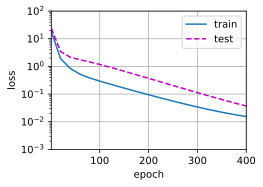

In [10]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
        labels[:n_train], labels[n_train:])


weight: [[3.7534232 2.872729 ]]


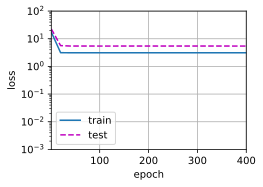

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
        labels[:n_train], labels[n_train:])

weight: [[ 4.9879785   1.2038924  -3.345879    5.449019   -0.4159771   1.2081243
  -0.07252846  0.17218466  0.16118328 -0.10015679 -0.13474426  0.10165296
   0.21302713  0.21049438  0.0354336  -0.12919927 -0.11660017  0.20156702
  -0.02168053 -0.12451034]]


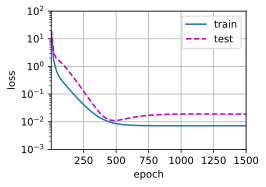

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
        labels[:n_train], labels[n_train:], num_epochs=1500)